In [10]:
import torch
import arcsim
import gc
import time
import json
import sys

from pytorch3d.structures import Meshes
import matplotlib.pyplot as plt
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj, save_obj, IO

from mpl_toolkits.mplot3d import Axes3D

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    SoftSilhouetteShader,
    Textures
)


json
separate obs
create bvh
find ixns
separate obs finish
tensor([[ 2.8599e-03,  5.6039e-01, -8.7478e-01],
        [ 9.9714e-01,  5.6039e-01, -8.7478e-01],
        [ 9.9719e-01,  9.9996e-01, -1.8564e-03],
        [ 2.8090e-03,  9.9996e-01, -1.8564e-03],
        [ 5.0000e-01,  8.6492e-01, -4.8208e-01],
        [ 5.0000e-01,  1.0467e+00, -1.6514e-02],
        [ 5.0000e-01,  5.3773e-01, -8.4027e-01],
        [ 9.9968e-01,  8.6063e-01, -4.8062e-01],
        [ 3.2287e-04,  8.6063e-01, -4.8062e-01],
        [ 7.5004e-01,  9.6221e-01, -2.5181e-01],
        [ 7.4887e-01,  7.3632e-01, -6.9654e-01],
        [ 2.4996e-01,  9.6221e-01, -2.5181e-01],
        [ 2.5113e-01,  7.3632e-01, -6.9654e-01],
        [ 2.5001e-01,  8.6539e-01, -4.8234e-01],
        [ 1.4132e-03,  7.2564e-01, -6.9091e-01],
        [ 3.5524e-03,  9.2196e-01, -2.3888e-01],
        [ 9.9645e-01,  9.2196e-01, -2.3888e-01],
        [ 7.4999e-01,  8.6539e-01, -4.8234e-01],
        [ 5.0000e-01,  7.4572e-01, -7.0152e-01],
        [ 

/home/ruben/anaconda3/envs/cloth-clone/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:530: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


step=0
forward time=5.967202186584473
backward time=16.7731511592865
step 0: g=tensor([ 0.0000,  0.0000, -9.8000], dtype=torch.float64) loss=0.46380734464481094 grad=tensor([ 6.1015e-14,  4.7820e-03, -3.5375e-03], dtype=torch.float64)



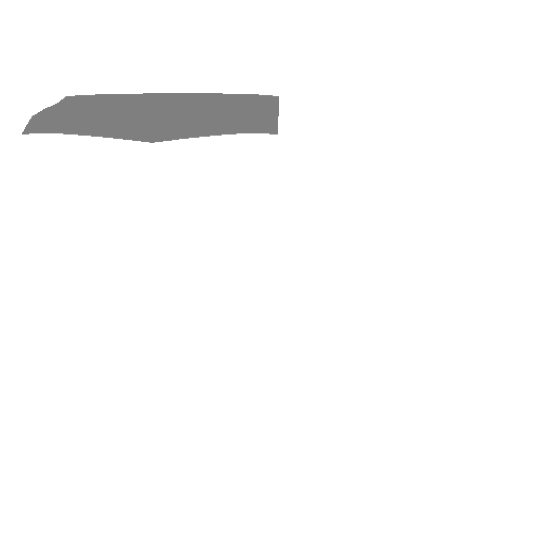

In [17]:
sys.path.append('../pysim')

pytorch_mesh = 0

with open('conf/gravity.json','r') as f:
	config = json.load(f)
matfile = config['cloths'][0]['materials'][0]['data']
with open(matfile,'r') as f:
	matconfig = json.load(f)

def save_config(config, file):
	with open(file,'w') as f:
		json.dump(config, f)

save_config(matconfig, 'curmat.json')
config['cloths'][0]['materials'][0]['data'] = 'curmat.json'
save_config(config, 'curconf.json')


torch.set_num_threads(8)
sim=arcsim.get_sim()

def reset_sim():
	arcsim.init_physics('curconf.json','',False)
	g = sim.gravity
	g.requires_grad = True
	return g

def run_sim():
	for step in range(49):
		arcsim.sim_step()

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 100)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

def get_loss():
    global pytorch_mesh
    vec = torch.tensor([0,0,-1],dtype=torch.float64)
    ans = torch.zeros([],dtype=torch.float64)
    cnt = 0
    for node in sim.cloths[0].mesh.nodes:
        cnt += 1
        ans = ans + torch.dot(node.x,vec)

    verts_tensor = torch.tensor([], dtype=torch.float32)
    for node in sim.cloths[0].mesh.nodes:
        verts_tensor = torch.cat((verts_tensor, node.x))



    faces_tensor = torch.tensor([], dtype=torch.int)

    for face in sim.cloths[0].mesh.faces:
        faces_tensor = torch.cat((faces_tensor, torch.tensor(
            [face.vertices[0].index, face.vertices[1].index, face.vertices[2].index])))


    verts_tensor = verts_tensor.view(-1,3).to(dtype=torch.float32)
    faces_tensor = faces_tensor.view(-1,3)

    print(verts_tensor)
    print(faces_tensor)

    verts_rgb_color = torch.ones([1, len(sim.cloths[0].mesh.nodes), 3])
    tex = Textures(verts_rgb=verts_rgb_color)
    pytorch_mesh = Meshes(verts=[verts_tensor], faces=[faces_tensor], textures=tex)
    pytorch_mesh = pytorch_mesh.to("cuda:0")

    print(verts_tensor.dtype, faces_tensor.dtype, verts_rgb_color.dtype)


    IO().save_mesh(pytorch_mesh, "cloth_mesh_0.obj")

    verts, faces, aux = load_obj("cloth_mesh_0.obj", device="cuda:0")
    faces_idx = faces.verts_idx
    trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

    R, T = look_at_view_transform(2.7, 0, 180) 
    cameras = FoVPerspectiveCameras(device="cuda:0", R=R, T=T)

    raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    )
    lights = PointLights(device="cuda:0", location=[[0.0, 0.0, -3.0]])

    renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device="cuda:0", 
        cameras=cameras,
        lights=lights
    )
    )
    images = renderer(pytorch_mesh)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].detach().cpu().numpy())
    plt.axis("off");
    plt.show()


    print(pytorch_mesh.isempty())
    
    return ans / cnt

	


lr = 10

with open('log.txt','w',buffering=1) as f:
	tot_step = 1
	for cur_step in range(tot_step):
		g = reset_sim()
		st = time.time()
		run_sim()
		en0 = time.time()
		loss = get_loss()
		print('step={}'.format(cur_step))
		print('forward time={}'.format(en0-st))
		loss.backward()
		en1 = time.time()
		print('backward time={}'.format(en1-en0))
		f.write('step {}: g={} loss={} grad={}\n'.format(cur_step, g.data, loss.data, g.grad.data))
		print('step {}: g={} loss={} grad={}\n'.format(cur_step, g.data, loss.data, g.grad.data))
		g.data -= lr * g.grad
		config['gravity'] = g.detach().numpy().tolist()
		save_config(config, 'curconf.json')
	




In [34]:
verts, faces, aux = load_obj("cloth_mesh_0.obj")
faces_idx = faces.verts_idx
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

/home/ruben/anaconda3/envs/cloth-clone/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:530: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


/tmp/ipykernel_11188/2153666403.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


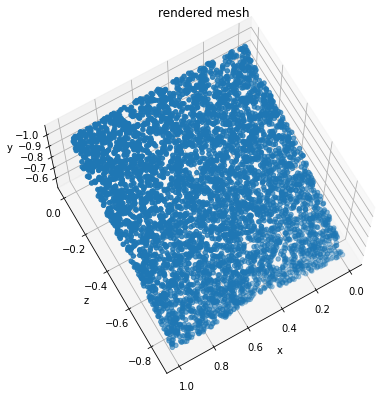

In [41]:
points = sample_points_from_meshes(trg_mesh, 5000)
x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig)
ax.scatter3D(x, z, -y)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.set_title("rendered mesh")
ax.view_init(250, 120)
plt.show()

